# IOT RSA Token

> 3000 | INTERNET OF THINGS 
>
> We were able to get our hands on a RSA token that is used as 2FA for a website. From the token, we sniffed some data (capture.logicdata) and took some photos of the token. Lastly, we found a key written at the back of the token, the contents of which we placed into key.txt. Unfortunately, we dropped the token in the toilet bowl and it is no longer working. Using the data sniffed and the photos (rsa_token_setup.png and welcome_msg.png) taken, make sense of the data that is displayed on the rsa token, help us predict what the next rsa token will be!
>
> [Login Page](http://yhi8bpzolrog3yw17fe0wlwrnwllnhic.alttablabs.sg:40551/)
>
> [Attachment: iot-challenge-5.zip](files/challenge/iot-challenge-5.zip)

Writeup by [@4yn](https://github.com/4yn)

My team Mushroom didn't complete this challenge while the CTF was running. I wasted 6 hours near the 20 hour mark of the CTF trying to decode I2C packets into character data by replaying the packets on an actual LCD, but I only managed to do so 2 hours before the contest was going to end, and that wasn't enough time to figure out the key generation algorithm. Here's the solution that was completed after the CTF had ended.

Respect to team SIG0CT that was the only category 2 team to solve during contest!

[A tl;dr solution is available below](#Summary)

## What we have to work with

Login page has fields for "Username", "Password" and "Token", and nothing else too suspicious. The description sounds about right, we will need to derive a valid token / one time password to be keyed into this portal.

![Web portal screenshot](files/images/web-portal.png)

In [1]:
!file challenge/iot-challenge-5.zip
!unzip -o challenge/iot-challenge-5.zip

challenge/iot-challenge-5.zip: Zip archive data, at least v2.0 to extract
Archive:  challenge/iot-challenge-5.zip
  inflating: capture.logicdata       
 extracting: key.txt                 
  inflating: rsa_token_setup.png     
  inflating: welcome_msg.png         


In [2]:
!cat key.txt

de ed a1 13 7a b0 12 02

`key.txt` has 8 bytes of data in hex format, so we will be looking for some sort of OTP algorithm that uses a 8 byte / 64 bit key.

![rsa_token_setup](files/rsa_token_setup.png)
_The "RSA Token"_

![rsa_token_setup](files/welcome_msg.png)
_A welcome message_

The images given show a [16 by 2 LCD screen with an I2C backpack](https://learn.adafruit.com/i2c-spi-lcd-backpack)*, which people often use with hardware projects with Arduinos or Raspberry Pis. The two data probes are connected to the SDA and SCL pins of the I2C backpack, which likely means `capture.logicdata` has a log of voltage levels sent over the I2C bus, so we should be able to figure out what packets were transmitted over the I2C bus. This also means that we probably only know what was displayed on the RSA token and have no way to inspect the actual token generation.

\* If you've never touched hardware before, you could probably figure this out by a [quick google of "screen sda scl"](https://www.google.com/search?q=lcd+sda+scl&tbm=isch)

## Extracting I2C Packets

Using  [Saleae Logic 1.2.18](https://www.saleae.com/downloads/) to open `capture.logicdata`, we find around 35 seconds of data capture. By zooming in we see channel 0 is alternating between high and low voltage and is probably the serial clock wire / "SCL", while the other channel 1 would then be the serial data wire / "SDA". We can use Saleae Logic's "Analyzer" feature to interpret the signals on the two channels for us, where we then get a log of all the I2C packets transmitted in hex format. Finally, we can export this into a CSV format for further processing.

![Saleae screenshot](files/images/saleae.png)

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('logic-export.csv')
print(df.shape)
df.head()

(1443, 6)


,Time [s],Packet ID,Address,Data,Read/Write,ACK/NAK
0,1.396228,1,0x4E,0x00,Write,ACK
1,1.496450,2,0x4E,0x34,Write,ACK
2,1.496680,3,0x4E,0x30,Write,ACK
3,1.501438,4,0x4E,0x34,Write,ACK
4,1.501668,5,0x4E,0x30,Write,ACK


In [5]:
df['hex_data'] = df['Data'].map(lambda x: x[2:])
df.head()

,Time [s],Packet ID,Address,Data,Read/Write,ACK/NAK,hex_data
0,1.396228,1,0x4E,0x00,Write,ACK,00
1,1.496450,2,0x4E,0x34,Write,ACK,34
2,1.496680,3,0x4E,0x30,Write,ACK,30
3,1.501438,4,0x4E,0x34,Write,ACK,34
4,1.501668,5,0x4E,0x30,Write,ACK,30


In [6]:
# I2C addresses used
df['Address'].value_counts()

0x4E    1443
Name: Address, dtype: int64

In [7]:
# Read or Write operations
df['Read/Write'].value_counts()

Write    1443
Name: Read/Write, dtype: int64

In [8]:
# Min and max data transmitted per packet
df['hex_data'].str.len().min(), df['hex_data'].str.len().max()

(2, 2)

<AxesSubplot:ylabel='Frequency'>

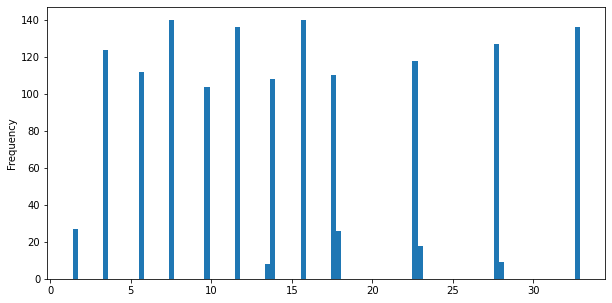

In [9]:
df['Time [s]'].plot.hist(bins=100, figsize=(10, 5))

For this data capture, looks like there wasonly one I2C device at address `0x4E`. This packet received only write operations with only one byte of data per transmission, and received 1443 packets in total. This means that there aren't any other devices that sent or received data. Packets also seemed to be sent in "bursts" from 20 to 150 packets in one conversation. Now we can take these packets and try to decipher what text was shown on the LCD.

But first, `0x4E`? Actually this is not very correct - Saleae logic's I2C analyzer for some reason concatenates the 7 bit device address with the 1 bit read/write flag. The I2C backpacks used with the 1602 LCDs are usually at address `0x27`. Sure enough, if we unpack the first 7 bits we get the address `0x27`.

In [10]:
# Packets sent to address 0x27 with 0 r/w flag indicating write operation
hex(0x4E >> 1), 0x4E & 1

('0x27', 0)

## 1602 LCD + I2C Backpack Message Reconstruction

Right before the CTF had ended, I managed to replay the I2C packets to an actual 1602 LCD + I2C backpack setup on an arduino. That method can be found further below and was extremely time consuming. After the CTF had ended some guys on discord also found a javascript 1602 emulator online that could definitely work. Alas, it turns out there was a much simpler way to decipher the packet protocol that can be done statically with some reading up.

What happens if we directly convert packets into string?

In [11]:
" ".join(list(df['hex_data']))[200:400]

' 6D 69 3D 39 7D 79 4D 49 6D 69 6D 69 2D 29 0D 09 CC C8 0C 08 2D 29 0D 09 7D 79 7D 79 6D 69 5D 59 6D 69 CD C9 6D 69 3D 39 6D 69 FD F9 6D 69 DD D9 6D 69 5D 59 2D 29 0D 09 7D 79 4D 49 6D 69 FD F9 2D 29 0'

In [12]:
bytes.fromhex("".join(list(df['hex_data']))[200:400])

b'i\xcd\xc9mi=9mi\xfd\xf9mi\xdd\xd9mi]Y-)\r\t}yMImi\xfd\xf9-)\r\tmi\x9d\x99mi\xfd\xf9}yMI-)\r\t\x0c\x08\x1c\x18\x0c\x08,(-)\r\t}y]Y}y=9mi]Y}y-)mi\xed\xe9mi\x1d\x19mi\xdd\xd9mi]Y=9\xad\xa9-'

Well turns out we get a lot of junk - the protocol seems to be a bit more complex than just writing raw ASCII bytes. One pattern that you might recognise is that the low nibble seems to alternate between `D` or `9`, and the upper nibble seems to repeat itself:

```
6  6  3  3  7  7  4  4
6D 69 3D 39 7D 79 4D 49
 D     D     D     D    
    9     9     9     9 
```

In [13]:
df['high_nibble'] = df['hex_data'].map(lambda x: x[0])
df['low_nibble'] = df['hex_data'].map(lambda x: x[1])
df.iloc[200:400]

,Time [s],Packet ID,Address,Data,Read/Write,ACK/NAK,hex_data,high_nibble,low_nibble
200,5.555094,213,0x4E,0x29,Write,NAK,29,2,9
201,5.555328,214,0x4E,0x0D,Write,NAK,0D,0,D
202,5.555558,215,0x4E,0x09,Write,NAK,09,0,9
203,5.555802,216,0x4E,0xCC,Write,ACK,CC,C,C
204,5.556032,217,0x4E,0xC8,Write,ACK,C8,C,8
...,...,...,...,...,...,...,...,...,...
395,7.604218,421,0x4E,0x7D,Write,NAK,7D,7,D
396,7.604448,423,0x4E,0x79,Write,Missing ACK/NAK,79,7,9
397,7.604682,424,0x4E,0x2D,Write,NAK,2D,2,D
398,7.604911,425,0x4E,0x29,Write,NAK,29,2,9


With some intuition, if we extract all the high nibbles that were sent twice with low nibbles of `D` and then `9`, we get a hex string that is the text we are looking for!

In [14]:
msg_nibbles = []
for i in range(len(df) - 1):
    if df['low_nibble'].iloc[i] == 'D' and df['low_nibble'].iloc[i+1] == '9':
        msg_nibbles.append(df['high_nibble'].iloc[i])
msg_hex = "".join(msg_nibbles)
msg_bytes = bytes.fromhex(msg_hex)
msg_bytes

b' govtech ctf  welcome to iot  username:  govtechstack  password:    G0vT3cH!3sP@$$w0rD key: deeda1137ab01202  Qns of the day ?????????????? When was govtech founded? p.s the time was 9:06:50 GMT+08 09/11/20 10:44:50       461177 09/11/20 10:45:50       107307 09/11/20 10:46:50       233790 09/11/20 10:47:50       722277 '

Why the weird protocol? It turns out that the 1602 LCD + I2C backpack setup was operating in '4-bit' mode. Each character byte to be printed on the LCD screen via I2C backpack are transmitted 4 bits at a time as the high nibble of a packet, and even then each nibble may need to be sent multiple times with appropriate timing and different 'command' low nibble due to I2C backpack specifications. You could learn more about this by inspecting the source code of the [Arduino library implementation for the I2C LCD](https://github.com/fdebrabander/Arduino-LiquidCrystal-I2C-library/blob/master/LiquidCrystal_I2C.cpp#L206):

```c++
void LiquidCrystal_I2C::send(uint8_t value, uint8_t mode) {
    // For each character to be printed, writes the character in 2 batches of 4 bits each
	uint8_t highnib=value&0xf0;
	uint8_t lownib=(value<<4)&0xf0;
	write4bits((highnib)|mode);
	write4bits((lownib)|mode);
}

void LiquidCrystal_I2C::pulseEnable(uint8_t _data){
    // Sends two I2C packets for each nibble with a different low command nibble
	expanderWrite(_data | En);	// En high
	delayMicroseconds(1);		// enable pulse must be >450ns

	expanderWrite(_data & ~En);	// En low
	delayMicroseconds(50);		// commands need > 37us to settle
}
```

Other helpful resources I found after the CTF are available [here](https://os.mbed.com/users/wim/notebook/textlcd-enhanced/) and [here](https://diyi0t.com/lcd-display-tutorial-for-arduino-and-esp8266/). But for the purposes of the CTF, we have what we need, so don't think too much and carry on.

## RSA???

Using the message dumped from the I2C packets, we can begin to reproduce the "RSA token" as mentioned in the challenge description.

In [15]:
msg_parts = [i for i in msg_bytes.decode('utf8').split(" ") if len(i)]
list(enumerate(msg_parts))

[(0, 'govtech'),
 (1, 'ctf'),
 (2, 'welcome'),
 (3, 'to'),
 (4, 'iot'),
 (5, 'username:'),
 (6, 'govtechstack'),
 (7, 'password:'),
 (8, 'G0vT3cH!3sP@$$w0rD'),
 (9, 'key:'),
 (10, 'deeda1137ab01202'),
 (11, 'Qns'),
 (12, 'of'),
 (13, 'the'),
 (14, 'day'),
 (15, '??????????????'),
 (16, 'When'),
 (17, 'was'),
 (18, 'govtech'),
 (19, 'founded?'),
 (20, 'p.s'),
 (21, 'the'),
 (22, 'time'),
 (23, 'was'),
 (24, '9:06:50'),
 (25, 'GMT+08'),
 (26, '09/11/20'),
 (27, '10:44:50'),
 (28, '461177'),
 (29, '09/11/20'),
 (30, '10:45:50'),
 (31, '107307'),
 (32, '09/11/20'),
 (33, '10:46:50'),
 (34, '233790'),
 (35, '09/11/20'),
 (36, '10:47:50'),
 (37, '722277')]

In [16]:
username = msg_parts[6]
password = msg_parts[8]
key = msg_parts[10]
username, password, key

('govtechstack', 'G0vT3cH!3sP@$$w0rD', 'deeda1137ab01202')

Inside the message, we seem to have found the username and password for the web portal. We also have the same key as the `key.txt` that was behind the original token.

In [17]:
" ".join(msg_parts[11:25])

'Qns of the day ?????????????? When was govtech founded? p.s the time was 9:06:50'

Not exactly sure what this does, but [a quick google](https://www.google.com/search?q=govtech+founded) tells us that Govtech was formally founded on 1st October 2016. Using that date and the time hint given we have a timestamp that we aren't too sure what we need to do with right now*.

\* DD/MM/YY format was guessed. We considered using MM/DD/YY when we were still deciding on a token generation algorithm.

In [18]:
founded_timestamp = "01/10/16 09:06:50"

In [19]:
token_history = [
    (msg_parts[26+i] + " " + msg_parts[27+i], msg_parts[28+i])
    for i in range(0,12,3)
]
token_history

[('09/11/20 10:44:50', '461177'),
 ('09/11/20 10:45:50', '107307'),
 ('09/11/20 10:46:50', '233790'),
 ('09/11/20 10:47:50', '722277')]

We are given 4 sets of timestamp and 6 digit tokens, which should be valid at the time of the data capture. Since we have the dates, this suggests that we need a [time-based one time password algorithm](https://en.wikipedia.org/wiki/Time-based_One-time_Password_algorithm) to convert a timestamp and a key to the valid token. Considering that the challenge description kept mentioning that the device was an "RSA token", the first thing that came to mind ([and to google](https://www.google.com/search?q=rsa+token)) was the RSA SecurID key that is often used as a second factor authentication in enterprise settings.

Unfortunately, I was stuck here up until the end of the CTF and was unable to obtain the flag during contest time. There is an implementation of the RSA SecurID token but this implementation appears to use a supplementary PIN on top of the key and did not have an easy way to import the 64 bit key from earlier. I tried using [wikipedia's implementation of generic HMAC-based OTP](https://en.wikipedia.org/wiki/HMAC-based_One-time_Password_algorithm#HOTP_value) with different hash functions, origin times, periods, key byte orders and time byte orders but that had no luck either. 

The CTF ended, the \#internet-of-things-spoilers channel on the CTF discord was opened and hints [were](https://discord.com/channels/773062343155908608/785159934798463017/785160413208641556) [given](https://discord.com/channels/773062343155908608/785159934798463017/785177932045090836). Turns out there was an [implementation of the RSA SecurID key generation algorithm](https://seclists.org/bugtraq/2000/Dec/459) available on a mailing list from way back in 2000*. After cleaning up some wrapped newlines and preliminary inspection of [`securid.c`](files/securid.c), this program ticked all the boxes that we needed: it generates tokens at a 1 minute interval (or 2 depending on setup) and effectively only uses 64 bits of a key (even though 320 bits are read from the input file). 

Note to self: OSINT harder.

\* Some [extra reading material](https://seclists.org/bugtraq/2001/Jan/87) gives interesting context and a nice history lesson

Given this c file, I wanted to convert it into a shared library to make experimentation easier - the most important goal was to wrap `void securid_hash_time((unsigned long time, OCTET *hash, OCTET key)` in something that could be callable. Changes were made and a modified [`libsecurid.c`](files/libsecurid.c) was completed and compiled into `libsecurid.so`, which was then interfaced using python `ctypes`.

In [20]:
!./compile-libsecurid.sh

In [21]:
from pathlib import Path
import ctypes
libsecurid = ctypes.CDLL(Path().absolute() / 'libsecurid.so')
libsecurid.securid_hash.restype = ctypes.c_longlong
def securid_hash(key, t):
    # t = t & (-4)
    res = libsecurid.securid_hash(ctypes.c_longlong(key), ctypes.c_long(t))
    res_hex = bytes.fromhex(hex(res)[-12:])[::-1].hex()
    return res_hex[:6], res_hex[6:]

By studying `securid.c`, we know the original `securid` algorithm reads the first 64 bits of a key string from a keyfile and packs it into a 64 bit integer with little endian byte order. The algorithm uses a timer counter that increases every 2 minutes, and calculates a hash using both the key and the counter. Depending if the current minute is odd or even, a different part of the hash will be used to derive the token.

After experimenting with the `securid` utility and various parameters, I found that the following changes allowed for generation of valid tokens which matched the tokens found earlier:
- Skipping key secret decryption inside `unsigned char read_line (FILE *fi, OCTET *outb)` (@ line 196 of `securid.c`)
- Skipping the minute offset `0x806880` used when calculating minutes since epoch (@ line 257 of `securid.c`)
- Parsing the key in little endian when converting to 64 bit integer within python
- Using epoch of the token as the "Govtech founding" timestamp within python, since everything is 50 seconds aligned!

The token generation equation was:
<!-- $$
\text{hash} = \text{brainard_hash} \left( \text{key}_\text{little endian},  4 \Big\lfloor \frac{T_\text{now} - T_\text{founding}}{120} \Big\rfloor \right)
$$ -->
<!-- <img src="https://render.githubusercontent.com/render/math?math=\text{hash}%20=%20\text{brainard_hash}%20\left(%20\text{key}_\text{little%20endian},%20%204%20\Big\lfloor%20\frac{T_\text{now}%20-%20T_\text{founding}}{120}%20\Big\rfloor%20\right)"> -->
![Securid equation](files/images/securid-equation.svg)

To confirm that the key is working, let's find what tokens would have been generated at the timestamps* from the I2C packet extraction.

\* We don't need to worry about timezones since both epoch and current time are at the same offset.

In [22]:
# Convert timestamps to seconds since epoch
from datetime import datetime
def date_string_to_epoch_seconds(date_string):
    return int(datetime.strptime(date_string, '%d/%m/%y %H:%M:%S').timestamp())
founded_t = date_string_to_epoch_seconds(founded_timestamp)
token_ts = [date_string_to_epoch_seconds(i[0]) for i in token_history]
tokens = [i[1] for i in token_history]
founded_t, token_ts, tokens

(1475284010,
 [1604889890, 1604889950, 1604890010, 1604890070],
 ['461177', '107307', '233790', '722277'])

In [23]:
# Convert key to little endian int
key_le = int(bytes.fromhex(key)[::-1].hex(), 16)
hex(key_le)

'0x212b07a13a1edde'

In [24]:
for token_t, token in zip(token_ts, tokens):
    print('Calculated:', securid_hash(key_le, (token_t - founded_t) // 120 * 4), 'Expected', token)

Calculated: ('461177', '107307') Expected 461177
Calculated: ('461177', '107307') Expected 107307
Calculated: ('233790', '722277') Expected 233790
Calculated: ('233790', '722277') Expected 722277


To get a token that is valid right now, we use the current timestamp! And some extra tokens for the next 2 minutes as well just in case they expire.

In [25]:
now_t = int(datetime.now().timestamp())
valid_tokens = [
    securid_hash(key_le, (now_t - founded_t) // 120 * 4),
    securid_hash(key_le, (now_t + 120 - founded_t) // 120 * 4)
]
valid_tokens = [j for i in valid_tokens for j in i]
valid_tokens

['997494', '936939', '251677', '638773']

Now we can submit the credentials and the token to the web portal.

In [26]:
import requests
url = 'http://yhi8bpzolrog3yw17fe0wlwrnwllnhic.alttablabs.sg:40551/login'
res = [
    requests.post(url, data={
        'username': username,
        'password': password,
        'token': valid_token
    })
    for valid_token in valid_tokens
]

In [27]:
[
    i.headers['content-type']
    for i in res
]

['application/zip', 'application/zip', 'application/zip', 'application/zip']

A valid login request will be returned with a zip file download. We can load the zip into a proper file, and inside will be the flag!

In [28]:
for i in res:
    if i.headers['content-type'] == 'application/zip':
        with open('success.zip', 'wb') as f:
            f.write(i.content)
        break

In [29]:
!file success.zip
!unzip -p success.zip flag.txt

success.zip: Zip archive data, at least v2.0 to extract
govtech-csg{!2c_rS@_Is_Qu!t3_c00I}

## Summary

The tl;dr Solution:
- Deduce 1206 LCD + I2C backpack circuit and from `rsa_token_setup.png` and `welcome_msg.png` 
- Convert `capture.logicdata` into I2C packets using Saleae Logic
- Convert I2C packets into printed characters by referring to hardware specification (and some intuition)
- OSINT the RSA SecurID algorithm
- Modify the RSA SecurID algorithm to fit the challenge setting
- Generate token and submit to web portal

I thought that this was an interesting multi-layered CTF challenge with an IOT/EE beginning, (somewhat?) OSINT middle and Crypto end. Quite a wild ride!

## Bonus: Hardware Replay Message Reconstruction

I happened to have a 1602 LCD + I2C backpack with me when I was doing the CTF. One of my first ideas on how to reconstruct the message printed on the LCD was to 'replay' the I2C packets to the physical screen! This meant that I had to recreate the data sent in each packet as well as the delay between packets (remember, the LCD screen protocol is sensitive to time and delays).

To do this, I converted the table of packets into a series of instructions that could be stored inside an Arduino microcontroller. Specifically, for each packet I would store the hex byte that was sent, the delay in microseconds (up to 1000) to the next packet and the delay in milliseconds (up to 10000) to the next packet in three C arrays, which would eventually be converted into a header file for into the Arduino. We split the delay into a millisecond and microsecond part so that everything fits nicely into a 16 bit integer.

One thing to note is that the timing of the bytes sent to the LCD is **very** crucial to the LCD working. During my initial exploration of this idea I had ignored the delay between packets that were sent in close succession to each other and sent the 200 or so bytes of data in a single I2C transmission with no delay between bytes. Unfortunately this means that the LCD doesn't accept the bytes properly and just prints gibberish. Even the delays of ~200 microseconds need to be preserved. Around 2 hours before the CTF was going to end I noticed [some suspicious delays inside the Arduino library implementation](https://github.com/fdebrabander/Arduino-LiquidCrystal-I2C-library/blob/master/LiquidCrystal_I2C.cpp#L238) and this led me to this final working method. 

In [30]:
# Calculate time to next packet
df['next_packet_time'] = df['Time [s]'].shift(-1).fillna(45)
df['delay'] = df['next_packet_time'] - df['Time [s]'] 
df.head()

,Time [s],Packet ID,Address,Data,Read/Write,ACK/NAK,hex_data,high_nibble,low_nibble,next_packet_time,delay
0,1.396228,1,0x4E,0x00,Write,ACK,00,0,0,1.496450,0.100222
1,1.496450,2,0x4E,0x34,Write,ACK,34,3,4,1.496680,0.000230
2,1.496680,3,0x4E,0x30,Write,ACK,30,3,0,1.501438,0.004758
3,1.501438,4,0x4E,0x34,Write,ACK,34,3,4,1.501668,0.000229
4,1.501668,5,0x4E,0x30,Write,ACK,30,3,0,1.502052,0.000384


In [31]:
# Calculate us and ms to next packet
# Make sure everything is less than 10 000 to avoid int overflow when we compile it
df['delay_us_total'] = (df['delay'] * 1000000).astype(int).clip(lower=1, upper=10000000)
df['delay_us'] = df['delay_us_total'].map(lambda x: x % 1000)
df['delay_ms'] = df['delay_us_total'].map(lambda x: x // 1000)
df.head()

,Time [s],Packet ID,Address,Data,Read/Write,ACK/NAK,hex_data,high_nibble,low_nibble,next_packet_time,delay,delay_us_total,delay_us,delay_ms
0,1.396228,1,0x4E,0x00,Write,ACK,00,0,0,1.496450,0.100222,100222,222,100
1,1.496450,2,0x4E,0x34,Write,ACK,34,3,4,1.496680,0.000230,229,229,0
2,1.496680,3,0x4E,0x30,Write,ACK,30,3,0,1.501438,0.004758,4758,758,4
3,1.501438,4,0x4E,0x34,Write,ACK,34,3,4,1.501668,0.000229,229,229,0
4,1.501668,5,0x4E,0x30,Write,ACK,30,3,0,1.502052,0.000384,384,384,0


In [32]:
# Convert the hex data sent to an integer
df['msgs'] = df['hex_data'].map(lambda x: int(x, 16))
df.head()

,Time [s],Packet ID,Address,Data,Read/Write,ACK/NAK,hex_data,high_nibble,low_nibble,next_packet_time,delay,delay_us_total,delay_us,delay_ms,msgs
0,1.396228,1,0x4E,0x00,Write,ACK,00,0,0,1.496450,0.100222,100222,222,100,0
1,1.496450,2,0x4E,0x34,Write,ACK,34,3,4,1.496680,0.000230,229,229,0,52
2,1.496680,3,0x4E,0x30,Write,ACK,30,3,0,1.501438,0.004758,4758,758,4,48
3,1.501438,4,0x4E,0x34,Write,ACK,34,3,4,1.501668,0.000229,229,229,0,52
4,1.501668,5,0x4E,0x30,Write,ACK,30,3,0,1.502052,0.000384,384,384,0,48


In [33]:
# Generate the replay.h file for the microcontroller
fields = ['msgs', 'delay_us', 'delay_ms']
datatypes = ['uint8_t', 'uint16_t', 'uint16_t']
code = []
code.append("#include <avr/pgmspace.h>")
code.append(f"const int PROGMEM msg_len = {len(df)};")
for field, datatype in zip(fields, datatypes):
    code.append(
        f"const {datatype} PROGMEM {field}[{len(df[field])}] = " +
        "{" +
        ", ".join([
            str(i)
            for i in list(df[field])
        ]) +
        "};"
    )
print(
    "\n".join([
        line[:100] + ("" if len(line) < 100 else "...")
        for line in code
    ])
)

#include <avr/pgmspace.h>
const int PROGMEM msg_len = 1443;
const uint8_t PROGMEM msgs[1443] = {0, 52, 48, 52, 48, 52, 48, 36, 32, 36, 32, 132, 128, 4, 0, 196, ...
const uint16_t PROGMEM delay_us[1443] = {222, 229, 758, 229, 384, 229, 389, 229, 384, 229, 234, 229,...
const uint16_t PROGMEM delay_ms[1443] = {100, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...


In [36]:
with open('hardware-replay/replay.h', 'w') as f:
    f.write("\n".join(code))

Now, we just need to program a microcontroller to replay packets to the LCD. Source code for this is available inside [`hardware-replay/hardware-replay.ino`](files/hardware-replay/hardware-replay.ino). As a side note, I had to learnnow to [store arduino variables in ROM](https://www.arduino.cc/reference/en/language/variables/utilities/progmem/) to fit the entire payload inside the microcontroller - the payload would not fit into the [2.5kb of RAM available in an Ardunio Micro](https://store.arduino.cc/usa/arduino-micro) but it would work if we used the 32kb of ROM.

![Hardware replay](files/images/hardware-replay.png)

And success! We get the same message from earlier and can move onto the crypto part of the challenge. [Full video can be found here.](https://youtu.be/HGdp8noYVfE)